<a href="https://colab.research.google.com/github/mahanteshimath/DLT_HOME_WORK_Workshop-2.0/blob/main/MAHANTESH_Workshop_2_0_Part2_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

Write a python script that will load data from the Jikan API (Unofficial MyAnimeList API) into DuckDB using dlt and complete the tasks.

Jikan API URL: https://api.jikan.moe/v4

Docs: https://docs.api.jikan.moe/#section/Information



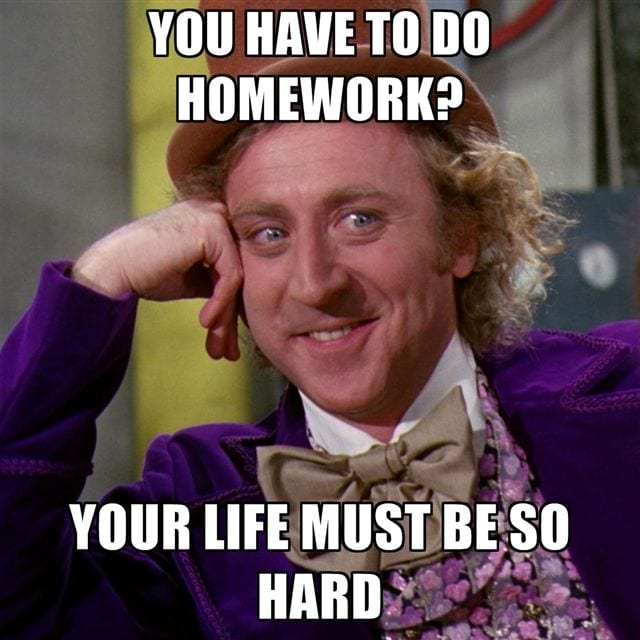

# Install dlt with duckdb extention

In [1]:
%%capture
!pip install dlt[duckdb]

# Task 1: Backfill your data & Retry on failures

Reuse your incremental pipeline from Part 1.

- [Backfill](https://dlthub.com/docs/general-usage/incremental-loading#using-end_value-for-backfill) animes released within the last 6 months (from March 1st until Septemper 1st).

- This API has [Rate Limits](https://docs.api.jikan.moe/#section/Information/Rate-Limiting). The pipeline can be retried, as covered in the workshop, and [demo](https://colab.research.google.com/drive/1wqeIv0nD6S9r8ImJEbZ_PYBgeE3C3kMO).

Read more about [incremental loading](https://dlthub.com/docs/general-usage/incremental-loading).


In [2]:
import time
import dlt
import requests
from datetime import datetime, timedelta

# Define the anime resource with backfill support and retry mechanism
@dlt.resource(table_name="anime", write_disposition="merge")
def get_anime():
    base_url = "https://api.jikan.moe/v4/anime"

    # Calculate the start and end date for the backfill (March 1st - September 1st)
    start_date = "2023-03-01"
    end_date = "2023-09-01"

    # Define the current page for pagination
    page = 1

    # Keep fetching data from the API with backfill date filter
    while True:
        params = {
            "page": page,
            "start_date": start_date,
            "end_date": end_date
        }

        # Make the request to the API and handle rate limits
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()  # Raises error if the response status is 4xx/5xx

            # Check if the response content is JSON
            if response.headers.get('Content-Type') == 'application/json':
                data = response.json()
            else:
                print(f"Unexpected content-type: {response.headers.get('Content-Type')}")
                print("Response text:", response.text)
                break  # Exit the loop if the response is not JSON

        except requests.exceptions.HTTPError as e:
            if response.status_code == 429:  # Handle rate limit
                print("Rate limit reached. Retrying after 60 seconds...")
                time.sleep(60)  # Wait for 60 seconds before retrying
                continue
            else:
                raise e  # Raise any other HTTP errors
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            break  # Exit the loop on other request errors

        # Yield the data for loading
        yield data["data"]

        # If there's no more data, break the loop
        if not data.get("pagination", {}).get("has_next_page", False):
            break

        # Increment the page for the next batch
        page += 1
        time.sleep(1)  # Small delay to respect rate limits


# Set up the pipeline configuration
pipeline = dlt.pipeline(
    pipeline_name='anime_pipeline',
    destination='duckdb',
    dataset_name='anime_data',
    dev_mode=True,
)

# Run the pipeline with the backfilled anime data
load_info = pipeline.run(get_anime())
print(load_info)


2024-10-17 19:00:09,702|[WARNING]|594|138673150349312|dlt|utils.py|verify_schema_merge_disposition:118|Table anime has `write_disposition` set to `merge` and `merge_strategy` set to `delete-insert`, but no primary or merge keys defined. dlt will fall back to `append` for this table.


Pipeline anime_pipeline load step completed in 2.62 seconds
1 load package(s) were loaded to destination duckdb and into dataset anime_data_20241017070001
The duckdb destination used duckdb:////content/anime_pipeline.duckdb location to store data
Load package 1729191601.7193236 is LOADED and contains no failed jobs


Run the code below and

## Answer the Questions:
**1.1.**  How many columns has `anime` table?

In [3]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
conn.sql(f"SET search_path = '{pipeline.dataset_name}'")
print(len(conn.sql("select * from anime").df().columns))
conn.sql("select * from anime").df()

52


,mal_id,url,images__jpg__image_url,images__jpg__small_image_url,images__jpg__large_image_url,images__webp__image_url,images__webp__small_image_url,images__webp__large_image_url,trailer__youtube_id,trailer__url,...,background,_dlt_load_id,_dlt_id,title_english,season,year,broadcast__day,broadcast__time,broadcast__timezone,broadcast__string
0,39905,https://myanimelist.net/anime/39905/Collar_x_M...,https://cdn.myanimelist.net/images/anime/1535/...,https://cdn.myanimelist.net/images/anime/1535/...,https://cdn.myanimelist.net/images/anime/1535/...,https://cdn.myanimelist.net/images/anime/1535/...,https://cdn.myanimelist.net/images/anime/1535/...,https://cdn.myanimelist.net/images/anime/1535/...,23LKtHrokvo,https://www.youtube.com/watch?v=23LKtHrokvo,...,,1729191601.7193236,noMCQFJ5o32/TQ,None,None,NaN,None,None,None,None
1,41220,https://myanimelist.net/anime/41220/Huo_Feng_L...,https://cdn.myanimelist.net/images/anime/1171/...,https://cdn.myanimelist.net/images/anime/1171/...,https://cdn.myanimelist.net/images/anime/1171/...,https://cdn.myanimelist.net/images/anime/1171/...,https://cdn.myanimelist.net/images/anime/1171/...,https://cdn.myanimelist.net/images/anime/1171/...,NEqqDX0rdCw,https://www.youtube.com/watch?v=NEqqDX0rdCw,...,,1729191601.7193236,gm+7LfRBpPcVEQ,The Ravages of Time,None,NaN,None,None,None,None
2,41503,https://myanimelist.net/anime/41503/Jintian_Ka...,https://cdn.myanimelist.net/images/anime/1394/...,https://cdn.myanimelist.net/images/anime/1394/...,https://cdn.myanimelist.net/images/anime/1394/...,https://cdn.myanimelist.net/images/anime/1394/...,https://cdn.myanimelist.net/images/anime/1394/...,https://cdn.myanimelist.net/images/anime/1394/...,None,None,...,,1729191601.7193236,9LAMhtvIY5PqfA,Super Star Season 2,None,NaN,None,None,None,None
3,44388,https://myanimelist.net/anime/44388/Biao_Ren__...,https://cdn.myanimelist.net/images/anime/1968/...,https://cdn.myanimelist.net/images/anime/1968/...,https://cdn.myanimelist.net/images/anime/1968/...,https://cdn.myanimelist.net/images/anime/1968/...,https://cdn.myanimelist.net/images/anime/1968/...,https://cdn.myanimelist.net/images/anime/1968/...,dNwN1MxMosM,https://www.youtube.com/watch?v=dNwN1MxMosM,...,Animated adaptation of Xianzhe Xu's (许先哲) manh...,1729191601.7193236,fvE5OtgLl6RdtQ,Blades of the Guardians,None,NaN,None,None,None,None
4,45486,https://myanimelist.net/anime/45486/Kuma_Kuma_...,https://cdn.myanimelist.net/images/anime/1132/...,https://cdn.myanimelist.net/images/anime/1132/...,https://cdn.myanimelist.net/images/anime/1132/...,https://cdn.myanimelist.net/images/anime/1132/...,https://cdn.myanimelist.net/images/anime/1132/...,https://cdn.myanimelist.net/images/anime/1132/...,zw5JCuSyo7I,https://www.youtube.com/watch?v=zw5JCuSyo7I,...,Kuma Kuma Kuma Bear Punch! was released on Blu...,1729191601.7193236,BDJyuqRNJIjOxA,None,spring,2023.0,Mondays,22:00,Asia/Tokyo,Mondays at 22:00 (JST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,57186,https://myanimelist.net/anime/57186/Heart_Cock...,https://cdn.myanimelist.net/images/anime/1624/...,https://cdn.myanimelist.net/images/anime/1624/...,https://cdn.myanimelist.net/images/anime/1624/...,https://cdn.myanimelist.net/images/anime/1624/...,https://cdn.myanimelist.net/images/anime/1624/...,https://cdn.myanimelist.net/images/anime/1624/...,None,None,...,,1729191601.7193236,N89kvaK2XCrYBg,None,summer,2023.0,None,None,None,Not scheduled once per week
110,57397,https://myanimelist.net/anime/57397/Aint_Backi...,https://cdn.myanimelist.net/images/anime/1911/...,https://cdn.myanimelist.net/images/anime/1911/...,https://cdn.myanimelist.net/images/anime/1911/...,https://cdn.myanimelist.net/images/anime/1911/...,https://cdn.myanimelist.net/images/anime/1911/...,https://cdn.myanimelist.net/images/anime/1911/...,None,None,...,,1729191601.7193236,7YweD9F650tbvg,None,None,NaN,None,None,None,None
111,59468,https://myanimelist.net/anime/59468/Menghuan_S...,https://cdn.myanimelist.net/

# Task 2: Get anime statistics with REST API source


- Create a pipeline using the [REST API source](https://dlthub.com/docs/devel/dlt-ecosystem/verified-sources/rest_api/basic), for the next endpoints:
  - [anime](https://docs.api.jikan.moe/#tag/anime/operation/getAnimeSearch)
  - [statistics](https://docs.api.jikan.moe/#tag/anime/operation/getAnimeStatistics) for each anime.
- Add pagination: [REST API source pagination documentation](https://dlthub.com/docs/devel/dlt-ecosystem/verified-sources/rest_api/basic#pagination).
- Set [limit](https://dlthub.com/docs/devel/general-usage/source#load-data-partially) to 2 pages, otherwise it will take forever.
- Use progress bar "log" or [any other](https://dlthub.com/docs/walkthroughs/run-a-pipeline#2-see-the-progress-during-loading).

Play with requests, check out what pagination parameters you can use.

In [4]:
import requests
response = requests.get("https://api.jikan.moe/v4/anime")
response.json()['pagination']

{'last_visible_page': 1100,
 'has_next_page': True,
 'current_page': 1,
 'items': {'count': 25, 'total': 27500, 'per_page': 25}}

#### Tips:
If you're stuck, look here

Pagination:
- for endpoint "anime" use pagination type "page_number" with params `"base_page": 1` and `"total_path": "pagination.last_visible_page"`
- for endpoint "statistics" use "single_page", because this endpoint has no pagination.

Limit:
- Use `add_limit` for `anime_source` as `anime_source.add_limit(2)`.  

### Write the pipeline:

https://api.jikan.moe/v4/anime/{id}/full

In [16]:
import os
import requests
import dlt
from dlt.sources.rest_api import RESTAPIConfig

# Define the REST API source for anime
class AnimeSource(RESTAPIConfig):
    def __init__(self):
        super().__init__(
            name="anime",
            base_url="https://api.jikan.moe/v4",
            endpoints={
                "anime": {
                    "path": "/anime",
                    "pagination": {
                        "type": "page_number",
                        "params": {
                            "base_page": 1,
                            "total_path": "pagination.last_visible_page"
                        }
                    }
                },
                "statistics": {
                    "path": "/anime/{id}/statistics",
                    "pagination": {
                        "type": "single_page"
                    }
                }
            }
        )

# Function to fetch anime statistics
def fetch_anime_statistics(anime_id):
    response = requests.get(f"https://api.jikan.moe/v4/anime/{anime_id}/statistics")
    return response.json()

# Initialize the anime source
anime_source = AnimeSource()

# Define the pipeline
pipeline = dlt.pipeline(
    pipeline_name="rest_api_anime",
    destination='duckdb',
    dataset_name="rest_api_data"
)

# Fetch anime data with pagination and limit
anime_data = []
page = 1
limit = 2
while page <= limit:
    response = requests.get(f"https://api.jikan.moe/v4/anime?page={page}")
    data = response.json()
    anime_data.extend(data['data'])
    page += 1

# Fetch statistics for each anime
for anime in anime_data:
    anime_id = anime['mal_id']
    anime['statistics'] = fetch_anime_statistics(anime_id)

# Wrap the data in a dlt.resource and provide a name
anime_resource = dlt.resource(anime_data, name="anime")

# Run the pipeline
load_info = pipeline.run(anime_resource)
print(load_info)
print(pipeline.last_trace)


Pipeline rest_api_anime load step completed in 1.53 seconds
1 load package(s) were loaded to destination duckdb and into dataset rest_api_data
The duckdb destination used duckdb:////content/rest_api_anime.duckdb location to store data
Load package 1729193095.8872268 is LOADED and contains no failed jobs
Run started at 2024-10-17 19:24:55.807554+00:00 and COMPLETED in 2.26 seconds with 4 steps.
Step extract COMPLETED in 0.07 seconds.

Load package 1729193095.8872268 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.48 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- anime: 50 row(s)
- anime__titles: 240 row(s)
- anime__producers: 164 row(s)
- anime__licensors: 75 row(s)
- anime__studios: 56 row(s)
- anime__genres: 160 row(s)
- anime__themes: 75 row(s)
- anime__statistics__data__scores: 170 row(s)
- anime__title_synonyms: 47 row(s)
- anime__demographics: 35 row(s)

Load package 1729193095.8872

If you set limit to 2 pages, you should have 50 rows in the `anime` table.

Run the code below and
## Answer the Questions:
**2.1** How many tables were created for statistics?

**2.2** How many rows has `statistics` table (regarding the SQL query below)? Make sure you set limit to 2 pages.

Look at the data:

In [34]:
import duckdb
from google.colab import data_table
data_table.enable_dataframe_formatter()

conn = duckdb.connect(f"{pipeline.pipeline_name}.duckdb")
# conn.sql(f"select COUNT(*) from rest_api_data.anime__statistics__data__scores")


# Connect to the DuckDB database and query the tables
conn = duckdb.connect(database='rest_api_anime.duckdb')

# List all tables
tables = conn.execute("SELECT count(*) FROM information_schema.tables").fetchall()
print("Tables:", tables)

# Query the statistics table
statistics_count = conn.execute("SELECT COUNT(*) FROM information_schema.tables").fetchone()[0]
print("Number of rows in statistics table:", statistics_count)





Tables: [(13,)]
Number of rows in statistics table: 13


# Task 3: Speed up your pipeline

- Use the same pipeline from Task 2.
- Use different configurations from the Performance Optimization section of the [workshop](https://colab.research.google.com/drive/1vzixI_gWhp_g9me2_raIW2qoo16n4q_f?usp=sharing) to speed up your pipeline.

Read more about [optimizing dlt](https://dlthub.com/docs/reference/performance).

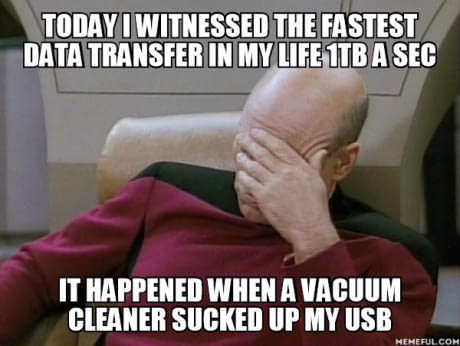

1. Imitate the worst case scenario. Run the pipeline with the '1' for the parameters below:

In [35]:
# SET UP ENV VARS
import os

os.environ['DATA_WRITER__BUFFER_MAX_ITEMS'] = '1'
os.environ['DATA_WRITER__FILE_MAX_ITEMS'] = '1'
os.environ['EXTRACT__WORKERS'] = '1'
os.environ['NORMALIZE__WORKERS'] = '1'
os.environ['LOAD__WORKERS'] = '1'

Step 2: Run the Pipeline with Worst-Case Scenario Settings
**bold text**

In [39]:
import requests
import dlt
from dlt.sources.rest_api import RESTAPIConfig

# Define the REST API source for anime
class AnimeSource(RESTAPIConfig):
    def __init__(self):
        super().__init__(
            name="anime",
            base_url="https://api.jikan.moe/v4",
            endpoints={
                "anime": {
                    "path": "/anime",
                    "pagination": {
                        "type": "page_number",
                        "params": {
                            "base_page": 1,
                            "total_path": "pagination.last_visible_page"
                        }
                    }
                },
                "statistics": {
                    "path": "/anime/{id}/statistics",
                    "pagination": {
                        "type": "single_page"
                    }
                }
            }
        )

# Function to fetch anime statistics
def fetch_anime_statistics(anime_id):
    response = requests.get(f"https://api.jikan.moe/v4/anime/{anime_id}/statistics")
    return response.json()

# Initialize the anime source
anime_source = AnimeSource()

# Define the pipeline
pipeline = dlt.pipeline(
    pipeline_name="rest_api_anime",
    destination='duckdb',
    dataset_name="rest_api_data",
    progress="log"
)

# Fetch anime data with pagination and limit
anime_data = []
page = 1
limit = 2
while page <= limit:
    response = requests.get(f"https://api.jikan.moe/v4/anime?page={page}")
    data = response.json()
    anime_data.extend(data['data'])
    page += 1

# Fetch statistics for each anime
for anime in anime_data:
    anime_id = anime['mal_id']
    anime['statistics'] = fetch_anime_statistics(anime_id)

# Wrap the data in a dlt.resource and provide a name
anime_resource = dlt.resource(anime_data, name="anime")

# Measure the time taken to run the pipeline
start_time = time.time()
load_info = pipeline.run(anime_resource)
end_time = time.time()

print(load_info)
print(pipeline.last_trace)
print(f"Time taken: {end_time - start_time} seconds")


---------------------------- Extract rest_api_anime ----------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 281.90 MB (12.40%) | CPU usage: 0.00%

---------------------------- Extract rest_api_anime ----------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
anime: 1  | Time: 0.00s | Rate: 104857.60/s
Memory usage: 281.90 MB (12.40%) | CPU usage: 0.00%

---------------------------- Extract rest_api_anime ----------------------------
Resources: 1/1 (100.0%) | Time: 0.04s | Rate: 22.85/s
anime: 50  | Time: 0.04s | Rate: 1274.42/s
Memory usage: 281.90 MB (12.40%) | CPU usage: 0.00%

---------------- Normalize rest_api_anime in 1729194300.352037 -----------------
Files: 0/50 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 282.07 MB (12.40%) | CPU usage: 0.00%

---------------- Normalize rest_api_anime in 1729194300.352037 -----------------
Files: 0/50 (0.0%) | Time: 0.00s | Rate: 0.00/s
Items: 0  | Time: 0.00s | Rate: 0.00/s
Memor

Run your REST API source pipeline:

#Step 3: Optimize the Pipeline
Now, we will optimize the pipeline by adjusting the parameters and finding the best configuration. We will try different values for the number of workers and measure the time taken for each configuration.

In [41]:
import os
import time

# Function to run the pipeline with given parameters and measure time
def run_pipeline(extract_workers, normalize_workers, load_workers):
    os.environ['EXTRACT__WORKERS'] = str(extract_workers)
    os.environ['NORMALIZE__WORKERS'] = str(normalize_workers)
    os.environ['LOAD__WORKERS'] = str(load_workers)

    # Define the pipeline
    pipeline = dlt.pipeline(
        pipeline_name="rest_api_anime",
        destination='duckdb',
        dataset_name="rest_api_data",
        progress="log"
    )

    # Measure the time taken to run the pipeline
    start_time = time.time()
    load_info = pipeline.run(anime_resource)
    end_time = time.time()

    print(f"Extract workers: {extract_workers}, Normalize workers: {normalize_workers}, Load workers: {load_workers}")
    print(f"Time taken: {end_time - start_time} seconds")
    return end_time - start_time

# Test different configurations
best_time = float('inf')
best_config = None

for extract_workers in [8]:
    for normalize_workers in [8]:
        for load_workers in [8]:
            time_taken = run_pipeline(extract_workers, normalize_workers, load_workers)
            if time_taken < best_time:
                best_time = time_taken
                best_config = (extract_workers, normalize_workers, load_workers)

print(f"Best configuration: Extract workers: {best_config[0]}, Normalize workers: {best_config[1]}, Load workers: {best_config[2]}")
print(f"Best time: {best_time} seconds")


2024-10-17 20:05:30,432|[WARNING]|594|138673150349312|dlt|logger.py|wrapper:25|The pipeline `run` method will now load the pending load packages. The data you passed to the run function will not be loaded. In order to do that you must run the pipeline again


------------------ Load rest_api_anime in 1729195438.5834734 -------------------
Jobs: 35/1072 (3.3%) | Time: 0.00s | Rate: 3058346.67/s
Memory usage: 326.36 MB (11.70%) | CPU usage: 0.00%

------------------ Load rest_api_anime in 1729195438.5834734 -------------------
Jobs: 93/1072 (8.7%) | Time: 1.01s | Rate: 92.21/s
Memory usage: 329.45 MB (11.80%) | CPU usage: 0.00%

------------------ Load rest_api_anime in 1729195438.5834734 -------------------
Jobs: 137/1072 (12.8%) | Time: 2.04s | Rate: 67.02/s
Memory usage: 329.54 MB (12.00%) | CPU usage: 0.00%

------------------ Load rest_api_anime in 1729195438.5834734 -------------------
Jobs: 182/1072 (17.0%) | Time: 3.04s | Rate: 59.78/s
Memory usage: 329.86 MB (11.90%) | CPU usage: 0.00%

------------------ Load rest_api_anime in 1729195438.5834734 -------------------
Jobs: 223/1072 (20.8%) | Time: 4.13s | Rate: 53.97/s
Memory usage: 330.60 MB (11.90%) | CPU usage: 0.00%

------------------ Load rest_api_anime in 1729195438.5834734 ---

In [42]:
import os
import time

# Function to run the pipeline with given parameters and measure time
def run_pipeline(extract_workers, normalize_workers, load_workers):
    os.environ['EXTRACT__WORKERS'] = str(extract_workers)
    os.environ['NORMALIZE__WORKERS'] = str(normalize_workers)
    os.environ['LOAD__WORKERS'] = str(load_workers)

    # Define the pipeline
    pipeline = dlt.pipeline(
        pipeline_name="rest_api_anime",
        destination='duckdb',
        dataset_name="rest_api_data",
        progress="log"
    )

    # Measure the time taken to run the pipeline
    start_time = time.time()
    load_info = pipeline.run(anime_resource)
    end_time = time.time()

    print(f"Extract workers: {extract_workers}, Normalize workers: {normalize_workers}, Load workers: {load_workers}")
    print(f"Time taken: {end_time - start_time} seconds")
    return end_time - start_time

# Test different configurations
best_time = float('inf')
best_config = None

for extract_workers in [8,16]:
    for normalize_workers in [8,16]:
        for load_workers in [8,16]:
            time_taken = run_pipeline(extract_workers, normalize_workers, load_workers)
            if time_taken < best_time:
                best_time = time_taken
                best_config = (extract_workers, normalize_workers, load_workers)

print(f"Best configuration: Extract workers: {best_config[0]}, Normalize workers: {best_config[1]}, Load workers: {best_config[2]}")
print(f"Best time: {best_time} seconds")


---------------------------- Extract rest_api_anime ----------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 331.54 MB (12.10%) | CPU usage: 0.00%

---------------------------- Extract rest_api_anime ----------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
anime: 1  | Time: 0.00s | Rate: 131072.00/s
Memory usage: 331.54 MB (12.10%) | CPU usage: 0.00%

---------------------------- Extract rest_api_anime ----------------------------
Resources: 1/1 (100.0%) | Time: 0.02s | Rate: 44.05/s
anime: 50  | Time: 0.02s | Rate: 2559.53/s
Memory usage: 331.54 MB (12.10%) | CPU usage: 0.00%

----------------- Normalize rest_api_anime in 1729195656.11203 -----------------
Files: 0/50 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 331.80 MB (12.10%) | CPU usage: 0.00%

----------------- Normalize rest_api_anime in 1729195656.11203 -----------------
Files: 0/50 (0.0%) | Time: 0.00s | Rate: 0.00/s
Items: 0  | Time: 0.00s | Rate: 0.00/s
Memor

2. How long it took? Like forever?

3. Speed up the pipeline. Don't run dlt pipeline with defaults, play with parameters, find the best configuration.

## Answer the Questions:

**3.** What was the optimal number of extract, normalize and load workers?

This question is open, because you can get different results for different machines and implementations